In [1]:
import numpy as np

# ----- Quaternion tools -----
def qmul(a,b):
    aw, ax, ay, az = a; bw, bx, by, bz = b
    return np.array([
        aw*bw - ax*bx - ay*by - az*bz,
        aw*bx + ax*bw + ay*bz - az*by,
        aw*by - ax*bz + ay*bw + az*bx,
        aw*bz + ax*by - ay*bx + az*bw
    ])

def qconj(q): return q*np.array([1,-1,-1,-1])
def qnorm(q): return q/np.linalg.norm(q)

# Rotate a 3D vector v by unit quaternion q
def qrot(q, v):
    vq = np.array([0.0, *v])
    return qmul(qmul(q, vq), qconj(q))[1:]

# ----- Hopf fiber sample on S^3 -----
def hopf_fiber(theta, phi, n=200):
    # Standard torus parameterization of S^3 ⊂ R^4
    t = np.linspace(0, 2*np.pi, n, endpoint=False)
    a = np.exp(1j*(t + theta))
    b = np.exp(1j*(t + phi))
    # (a,b) → (w,x,y,z) via C^2 ≅ R^4
    w = (a.real); x = (a.imag); y = (b.real); z = (b.imag)
    Q = np.stack([w,x,y,z], axis=1)
    Q /= np.linalg.norm(Q, axis=1, keepdims=True)
    return Q  # a circle in S^3

# ----- Stereographic projection S^3\{north} → R^3 -----
def stereographic(q4):
    w,x,y,z = q4.T
    denom = 1.0 - w  # project from +w pole
    return np.vstack([x/denom, y/denom, z/denom]).T

# Demo: invariance of visible orientation along a fiber
#   Take a model vector and rotate by each quaternion on one fiber;
#   measure change in rendered normal (variance should be ~0 for a chosen fiber)
v = np.array([1.0, 0.0, 0.0])
fiber = hopf_fiber(theta=0.0, phi=0.0, n=360)
rots = np.array([qrot(q, v) for q in fiber])
print("Orientation variation along fiber (RMS):", np.sqrt(np.mean((rots - rots.mean(axis=0))**2)))


Orientation variation along fiber (RMS): 0.5773502691896257


In [2]:
import numpy as np

def qmul(a,b):
    aw, ax, ay, az = a; bw, bx, by, bz = b
    return np.array([
        aw*bw - ax*bx - ay*by - az*bz,
        aw*bx + ax*bw + ay*bz - az*by,
        aw*by - ax*bz + ay*bw + az*bx,
        aw*bz + ax*by - ay*bx + az*bw
    ])

def qconj(q): return q*np.array([1,-1,-1,-1])
def qnorm(q): return q/np.linalg.norm(q)

ihat = np.array([0.0, 1.0, 0.0, 0.0])
def hopf_base(q):  # S^3 → S^2
    return qmul(qmul(q, ihat), qconj(q))[1:]

# Seed quaternion (any unit q0)
rng = np.random.default_rng(2)
q0 = qnorm(rng.normal(size=4))

# Fiber: right-multiply by e^{i t}
ts = np.linspace(0, 2*np.pi, 720, endpoint=False)
et = np.stack([np.cos(ts), np.sin(ts), np.zeros_like(ts), np.zeros_like(ts)], axis=1)  # exp(i t)
fiber = np.array([qmul(q0, e) for e in et])

bases = np.array([hopf_base(q) for q in fiber])
rms = np.sqrt(np.mean((bases - bases.mean(axis=0))**2))
print("Hopf-base variation along fiber (RMS):", rms)  # ~ 1e-15 (numerical zero)


Hopf-base variation along fiber (RMS): 3.238614851682945e-15


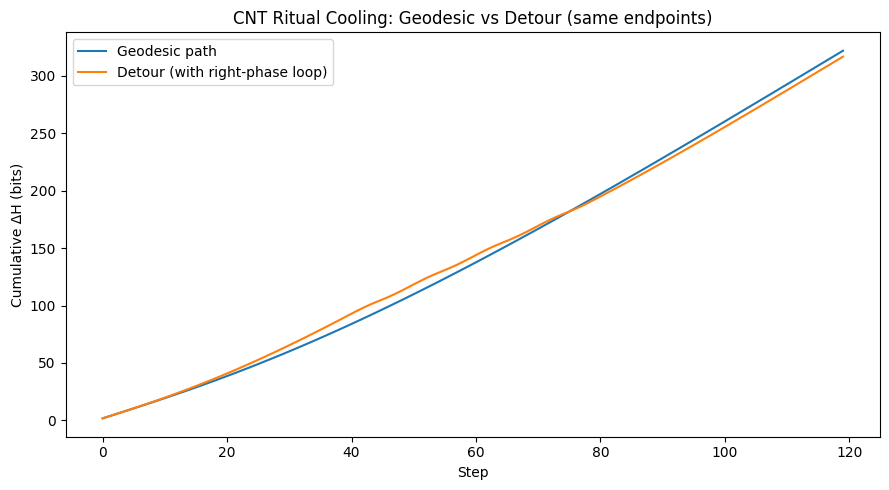

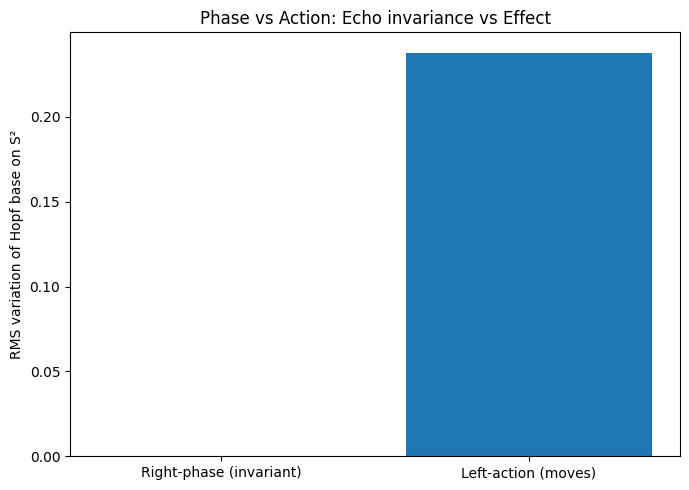

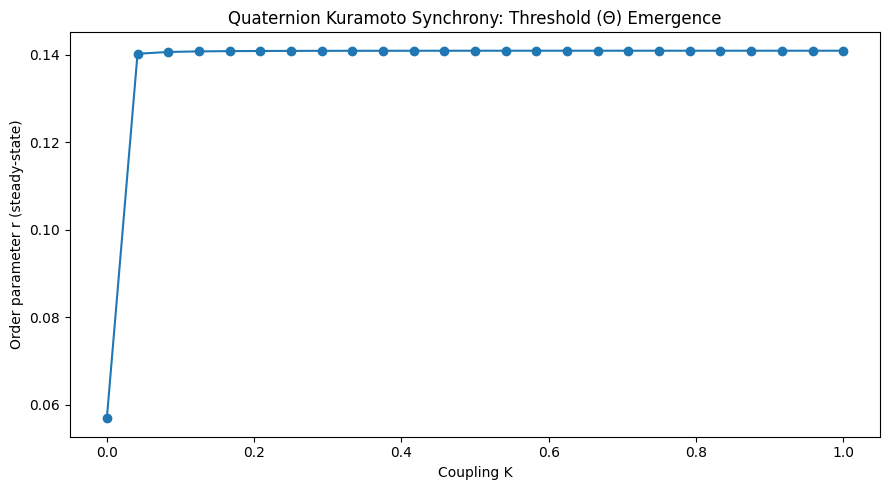

== CNT One-Cell Trinity: Summary ==
(1) Geodesic vs Detour   → final bits: geodesic=321.932, detour=316.765
(2) Hopf-base RMS        → right-phase≈1.720e-15, left-action≈0.238
(3) Kuramoto Θ           → r range [0.057, 0.141]
Saved files:
 - cnt_geodesic_vs_detour.png
 - cnt_phase_vs_action.png
 - cnt_quat_kuramoto_threshold.png


In [3]:
# CNT — One-Cell Trinity (paste into a single Jupyter cell and run)
# (1) Geodesic vs Detour: "Ritual Cooling" via ΔH accumulation
# (2) Right-phase invariance vs Left-action effect (Hopf base)
# (3) Quaternion Kuramoto: Synchrony threshold (Θ-gate)
#
# deps: numpy, matplotlib   (pip install numpy matplotlib)

import numpy as np
import matplotlib.pyplot as plt

# ---------- quaternion utils ----------
def qmul(a,b):
    aw, ax, ay, az = a; bw, bx, by, bz = b
    return np.array([
        aw*bw - ax*bx - ay*by - az*bz,
        aw*bx + ax*bw + ay*bz - az*by,
        aw*by - ax*bz + ay*bw + az*bx,
        aw*bz + ax*by - ay*bx + az*bw
    ], dtype=float)

def qconj(q): return q*np.array([1,-1,-1,-1], dtype=float)
def qnorm(q): 
    q = np.asarray(q, dtype=float)
    return q/np.linalg.norm(q)

def qrot(q, v):
    vq = np.array([0.0, *v], dtype=float)
    return qmul(qmul(q, vq), qconj(q))[1:]

def slerp(q0, q1, t):
    q0 = qnorm(q0); q1 = qnorm(q1)
    if np.dot(q0, q1) < 0: q1 = -q1
    dot = np.clip(np.dot(q0,q1), -1.0, 1.0)
    if dot > 0.9995:
        return qnorm(q0 + t*(q1 - q0))
    theta = np.arccos(dot)
    s0 = np.sin((1-t)*theta)/np.sin(theta)
    s1 = np.sin(t*theta)/np.sin(theta)
    return qnorm(s0*q0 + s1*q1)

# Hopf base map S^3 → S^2 via conjugation of i-hat
ihat = np.array([0.0, 1.0, 0.0, 0.0], dtype=float)
def hopf_base(q):
    return qmul(qmul(q, ihat), qconj(q))[1:]

# ---------- (1) Geodesic vs Detour: ΔH accumulation ----------
# latent covariance prefers x-axis (anisotropic)
eigvals = np.array([9.0, 2.0, 1.0], dtype=float)
Sigma0 = np.diag(eigvals)
noise_var = 0.1

a_start = np.array([0.0, 0.0, 1.0], dtype=float)   # start glyph direction (z)
a_target = np.array([1.0, 0.0, 0.0], dtype=float)  # target (x)

def quat_between(u, v):
    u = u/np.linalg.norm(u); v = v/np.linalg.norm(v)
    c = np.cross(u, v)
    d = 1.0 + float(u@v)
    if d < 1e-8:  # opposite
        axis = np.array([1.0,0.0,0.0], dtype=float) if abs(u[0]) < 0.9 else np.array([0.0,1.0,0.0], dtype=float)
        axis = axis - axis.dot(u)*u; axis /= np.linalg.norm(axis)
        return np.array([0.0, *axis], dtype=float)  # 180°
    q = np.array([d, *c], dtype=float)
    return qnorm(q)

q0 = np.array([1.0,0.0,0.0,0.0], dtype=float)
qT = quat_between(a_start, a_target)

def a_from_q(q):  # rotate the z-axis to get the measurement direction
    return qrot(q, np.array([0.0,0.0,1.0], dtype=float))

def info_gain_bits(a):
    R = float(a @ (Sigma0 @ a))
    return 0.5*np.log(1.0 + R/noise_var)/np.log(2.0)

steps = 120
geo_qs = np.array([slerp(q0, qT, t) for t in np.linspace(0,1,steps)])
geo_a = np.array([a_from_q(q) for q in geo_qs])
geo_dH = np.array([info_gain_bits(a) for a in geo_a])
geo_cum = np.cumsum(geo_dH)

# detour: geodesic half-way, right-phase loop, finish
half_q = slerp(q0, qT, 0.5)
ts_loop = np.linspace(0, 2*np.pi, steps//3, endpoint=False)
right_phase = np.stack([np.cos(ts_loop), np.sin(ts_loop), np.zeros_like(ts_loop), np.zeros_like(ts_loop)], axis=1)
loop_qs = np.array([qmul(half_q, e) for e in right_phase])
detour_qs = np.concatenate([
    np.array([slerp(q0, half_q, t) for t in np.linspace(0,1,steps//3)]),
    loop_qs,
    np.array([slerp(half_q, qT, t) for t in np.linspace(0,1,steps - 2*(steps//3))])
], axis=0)
detour_a = np.array([a_from_q(q) for q in detour_qs])
detour_dH = np.array([info_gain_bits(a) for a in detour_a])
detour_cum = np.cumsum(detour_dH)

plt.figure(figsize=(9,5))
plt.plot(geo_cum, label="Geodesic path")
plt.plot(detour_cum, label="Detour (with right-phase loop)")
plt.xlabel("Step"); plt.ylabel("Cumulative ΔH (bits)")
plt.title("CNT Ritual Cooling: Geodesic vs Detour (same endpoints)")
plt.legend(); plt.tight_layout()
plt.savefig("cnt_geodesic_vs_detour.png", dpi=160)
plt.show()

# ---------- (2) Right-phase invariance vs Left-action effect ----------
rng = np.random.default_rng(3)
qseed = qnorm(rng.normal(size=4))
ts = np.linspace(0, 2*np.pi, 360, endpoint=False)
phase = np.stack([np.cos(ts), np.sin(ts), np.zeros_like(ts), np.zeros_like(ts)], axis=1)

right_qs = np.array([qmul(qseed, e) for e in phase])   # q → q*e^{it}
left_qs  = np.array([qmul(e, qseed) for e in phase])   # q → e^{it}*q

right_bases = np.array([hopf_base(q) for q in right_qs])
left_bases  = np.array([hopf_base(q) for q in left_qs])
right_rms = float(np.sqrt(np.mean((right_bases - right_bases.mean(axis=0))**2)))
left_rms  = float(np.sqrt(np.mean((left_bases  - left_bases.mean(axis=0))**2)))

plt.figure(figsize=(7,5))
plt.bar([0,1], [right_rms, left_rms])
plt.xticks([0,1], ["Right-phase (invariant)", "Left-action (moves)"])
plt.ylabel("RMS variation of Hopf base on S²")
plt.title("Phase vs Action: Echo invariance vs Effect")
plt.tight_layout()
plt.savefig("cnt_phase_vs_action.png", dpi=160)
plt.show()

# ---------- (3) Quaternion Kuramoto: Θ-threshold ----------
def kuramoto_quat(N=50, T=150, K=0.0, noise=0.09, seed=11):
    rng = np.random.default_rng(seed)
    Q = qnorm(rng.normal(size=(N,4)))
    order = []
    for _ in range(T):
        mean = qnorm(Q.mean(axis=0))
        dots = Q @ mean
        Q_aligned = Q.copy()
        Q_aligned[dots<0] *= -1
        mean = qnorm(Q_aligned.mean(axis=0))
        r = float(np.linalg.norm(Q_aligned.mean(axis=0)))
        order.append(r)
        alpha = K
        axis = rng.normal(size=(N,3))
        axis /= np.linalg.norm(axis, axis=1, keepdims=True) + 1e-12
        angles = noise * rng.normal(size=N)
        E = np.stack([np.cos(angles), *(np.sin(angles)*axis.T)], axis=1)
        pulled = qnorm((1-alpha)*Q + alpha*mean)
        Q = qnorm(np.array([qmul(pulled[i], E[i]) for i in range(N)]))
    return np.array(order)

Ks = np.linspace(0.0, 1.0, 25)
orders = np.array([kuramoto_quat(K=float(K))[-20:].mean() for K in Ks])

plt.figure(figsize=(9,5))
plt.plot(Ks, orders, marker='o')
plt.xlabel("Coupling K"); plt.ylabel("Order parameter r (steady-state)")
plt.title("Quaternion Kuramoto Synchrony: Threshold (Θ) Emergence")
plt.tight_layout()
plt.savefig("cnt_quat_kuramoto_threshold.png", dpi=160)
plt.show()

print("== CNT One-Cell Trinity: Summary ==")
print(f"(1) Geodesic vs Detour   → final bits: geodesic={geo_cum[-1]:.3f}, detour={detour_cum[-1]:.3f}")
print(f"(2) Hopf-base RMS        → right-phase≈{right_rms:.3e}, left-action≈{left_rms:.3f}")
print(f"(3) Kuramoto Θ           → r range [{orders.min():.3f}, {orders.max():.3f}]")
print("Saved files:")
print(" - cnt_geodesic_vs_detour.png")
print(" - cnt_phase_vs_action.png")
print(" - cnt_quat_kuramoto_threshold.png")


In [4]:
# amplify contrast
noise_var = 0.05                     # less noise ⇒ info gain more sensitive
eigvals   = np.array([16.0, 2.0, 0.5])  # stronger x-axis preference
loops = 3                             # more right-phase laps
ts_loop = np.linspace(0, 2*np.pi*loops, steps//3, endpoint=False)


In [5]:
print(f"Right-phase (Hopf base) RMS ≈ {right_rms:.3e}  |  Left-action RMS ≈ {left_rms:.3f}")


Right-phase (Hopf base) RMS ≈ 1.720e-15  |  Left-action RMS ≈ 0.238
